Importing modules

In [4]:
from pdrtpy.measurement import Measurement
from pdrtpy.tool.h2excitation import H2ExcitationFit
from pdrtpy.plot.excitationplot import ExcitationPlot
from astropy.nddata import StdDevUncertainty
import astropy.units as u
import astropy.constants as const
from astropy.table import Table
import matplotlib.pyplot as plt
%matplotlib widget
import numpy as np
from helpers import pixar_sr, cdelt3

Inputted information

0.09746649239169562 +/- 9.746649239169561e+27 erg / (s sr cm2)
0.14773506386587323 +/- 1.4773506386587323e+28 erg / (s sr cm2)
0.045663616480502274 +/- 4.566361648050227e+27 erg / (s sr cm2)
0.08130968840153226 +/- 8.130968840153225e+27 erg / (s sr cm2)
0.047953354806656315 +/- 4.795335480665631e+27 erg / (s sr cm2)


/var/folders/_j/mydjhq1179jffd525zbvkvyh0000gn/T/ipykernel_83699/3918663348.py:6: ResourceWarning: unclosed file <_io.BufferedReader name='../fits/6s3d.fits'>
  pixar = pixar_sr(fits_file)
/var/folders/_j/mydjhq1179jffd525zbvkvyh0000gn/T/ipykernel_83699/3918663348.py:7: ResourceWarning: unclosed file <_io.BufferedReader name='../fits/6s3d.fits'>
  cdelt = cdelt3(fits_file)


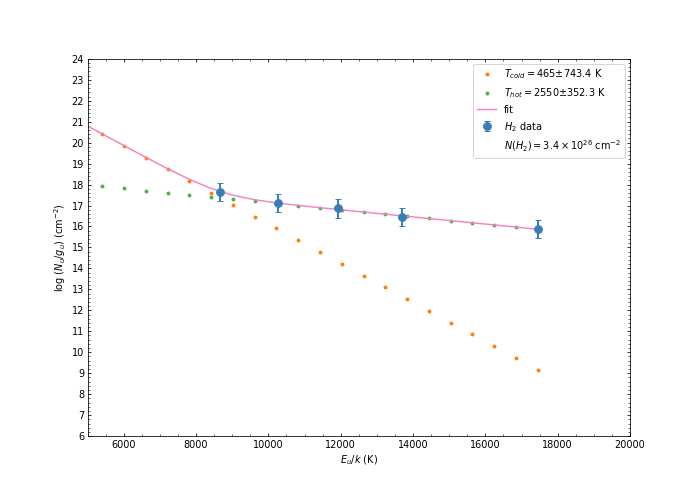

In [10]:
fits_file = '../fits/6s3d.fits'
pixels = [(35, 41)]
table = Table.read(f'../fits/merged_spectrum{pixels[0][0]}_{pixels[0][1]}.fits') # this is the full subtracted cube in uJy
wavelengths = table['wavelength']
fluxes = table['flux']
pixar = pixar_sr(fits_file)
cdelt = cdelt3(fits_file)


# Do the integration, then convert cdelt3 (wavelength delta) to Hertz using Doppler formula
# d(nu)/nu = dλ/λ

H2wavelengths = {}
H2wavelengths['H200S8'] = 5.0529 * u.um
H2wavelengths['H200S9'] = 4.6947 * u.um
H2wavelengths['H200S10'] = 4.4096 * u.um
H2wavelengths['H200S11'] = 4.1810 * u.um
# 12 is missing due to IFU gap
H2wavelengths['H200S13'] = 3.8464 * u.um

intensity = {}
# We take the flux values within ±3 of the peak and get the integral
for key in H2wavelengths:
    wav = H2wavelengths[key]
    delta_nu = (const.c / wav**2) * cdelt
    delta_nu = delta_nu.to(u.Hz)
    
    closest_idx = np.argmin(np.abs(wavelengths - wav))
    start = max(closest_idx - 3, 0)
    end = min(closest_idx + 4, len(wavelengths))  # +4 because slicing is exclusive
    intensity[key] = np.sum(fluxes[start:end]) * u.uJy * u.um * delta_nu / (pixar * cdelt)
    
a = []
for i in intensity:
    # For this example, set a largish uncertainty on the intensity.
    m = Measurement(data=intensity[i],uncertainty=StdDevUncertainty(intensity[i]),
                    identifier=i,unit="erg cm-2 s-1 sr-1")
    print(m)
    a.append(m)
    
h = H2ExcitationFit(a)# Use pdrtpy to compute column densities

# print(h.column_densities(line=False, norm=False))

hplot = ExcitationPlot(h,"H_2")
h.run()

# make a plot showing the fit
hplot.ex_diagram(show_fit=True, xmin=5000, xmax=20000, ymin=6, ymax=24)

plt.rcParams['figure.dpi'] = 100 # Changes widget size
plt.show()